## Segmentasi Wilayah Sosial

### Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

### A. Data Understanding

#### 1.Load Dataset

In [104]:
df = pd.read_csv("../data/segmentasi_raw_dataset.csv")
df.head()

,province,cities_reg,poorpeople_percentage,reg_gdp,life_exp,avg_schooltime,exp_percap
0,Aceh,Simeulue,18.98,2.275,65.240,9.48,7148
1,Aceh,Aceh Singkil,20.36,2.425,67.355,8.68,8776
2,Aceh,Aceh Selatan,13.18,5.531,64.360,8.88,8180
3,Aceh,Aceh Tenggara,13.41,5.063,68.155,9.67,8030
4,Aceh,Aceh Timur,14.45,10.616,68.705,8.21,8577


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   province               514 non-null    object 
 1   cities_reg             514 non-null    object 
 2   poorpeople_percentage  514 non-null    float64
 3   reg_gdp                514 non-null    float64
 4   life_exp               514 non-null    float64
 5   avg_schooltime         514 non-null    float64
 6   exp_percap             514 non-null    int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 28.2+ KB


In [106]:
df.describe()

,poorpeople_percentage,reg_gdp,life_exp,avg_schooltime,exp_percap
count,514.000000,514.000000,514.000000,514.000000,514.000000
mean,12.273152,34.798333,69.619076,8.436615,10324.787938
std,7.458703,84.155498,3.455911,1.630842,2717.144186
min,2.380000,1.042000,55.370000,1.420000,3976.000000
25%,7.150000,5.587500,67.336250,7.510000,8574.000000
50%,10.455000,13.068500,69.922500,8.305000,10196.500000
75%,14.887500,28.849500,72.018750,9.337500,11719.000000
max,41.660000,819.000000,77.855000,12.830000,23888.000000


#### 2. EDA (Exploratory Data Analysis)

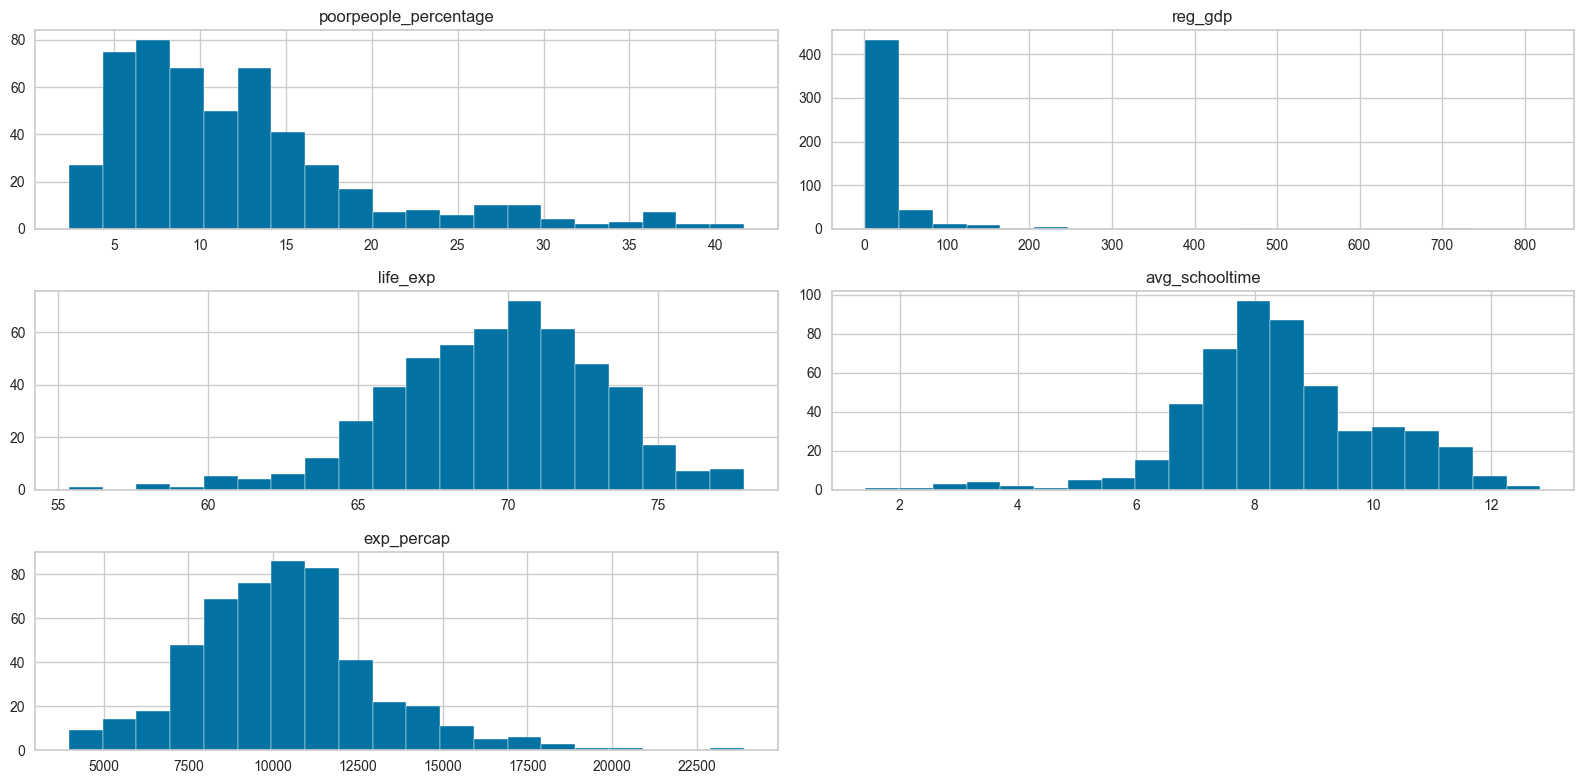

In [107]:
# Numerical & Categorical Features
numerical_features = df.select_dtypes(include=['float64','int64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

# Visualize Numerical Feature
df[numerical_features].hist(figsize=(16, 8), bins=20, edgecolor='white')
plt.subplots_adjust(hspace=0.4, wspace=20)
plt.tight_layout()
plt.show()

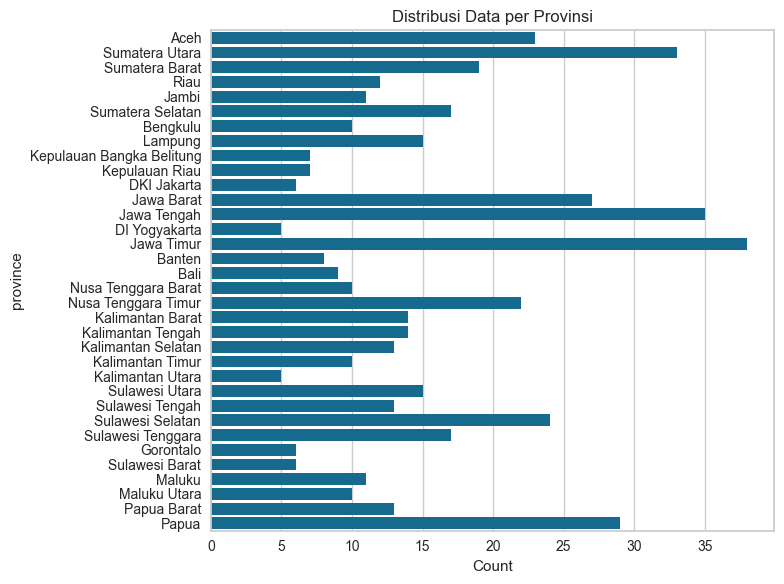

In [108]:

# Visualize Categorical Features
plt.figure(figsize=(8, 6))
sns.countplot(data=df, y='province')  
plt.xlabel("Count")
plt.title("Distribusi Data per Provinsi")
plt.tight_layout()
plt.show()

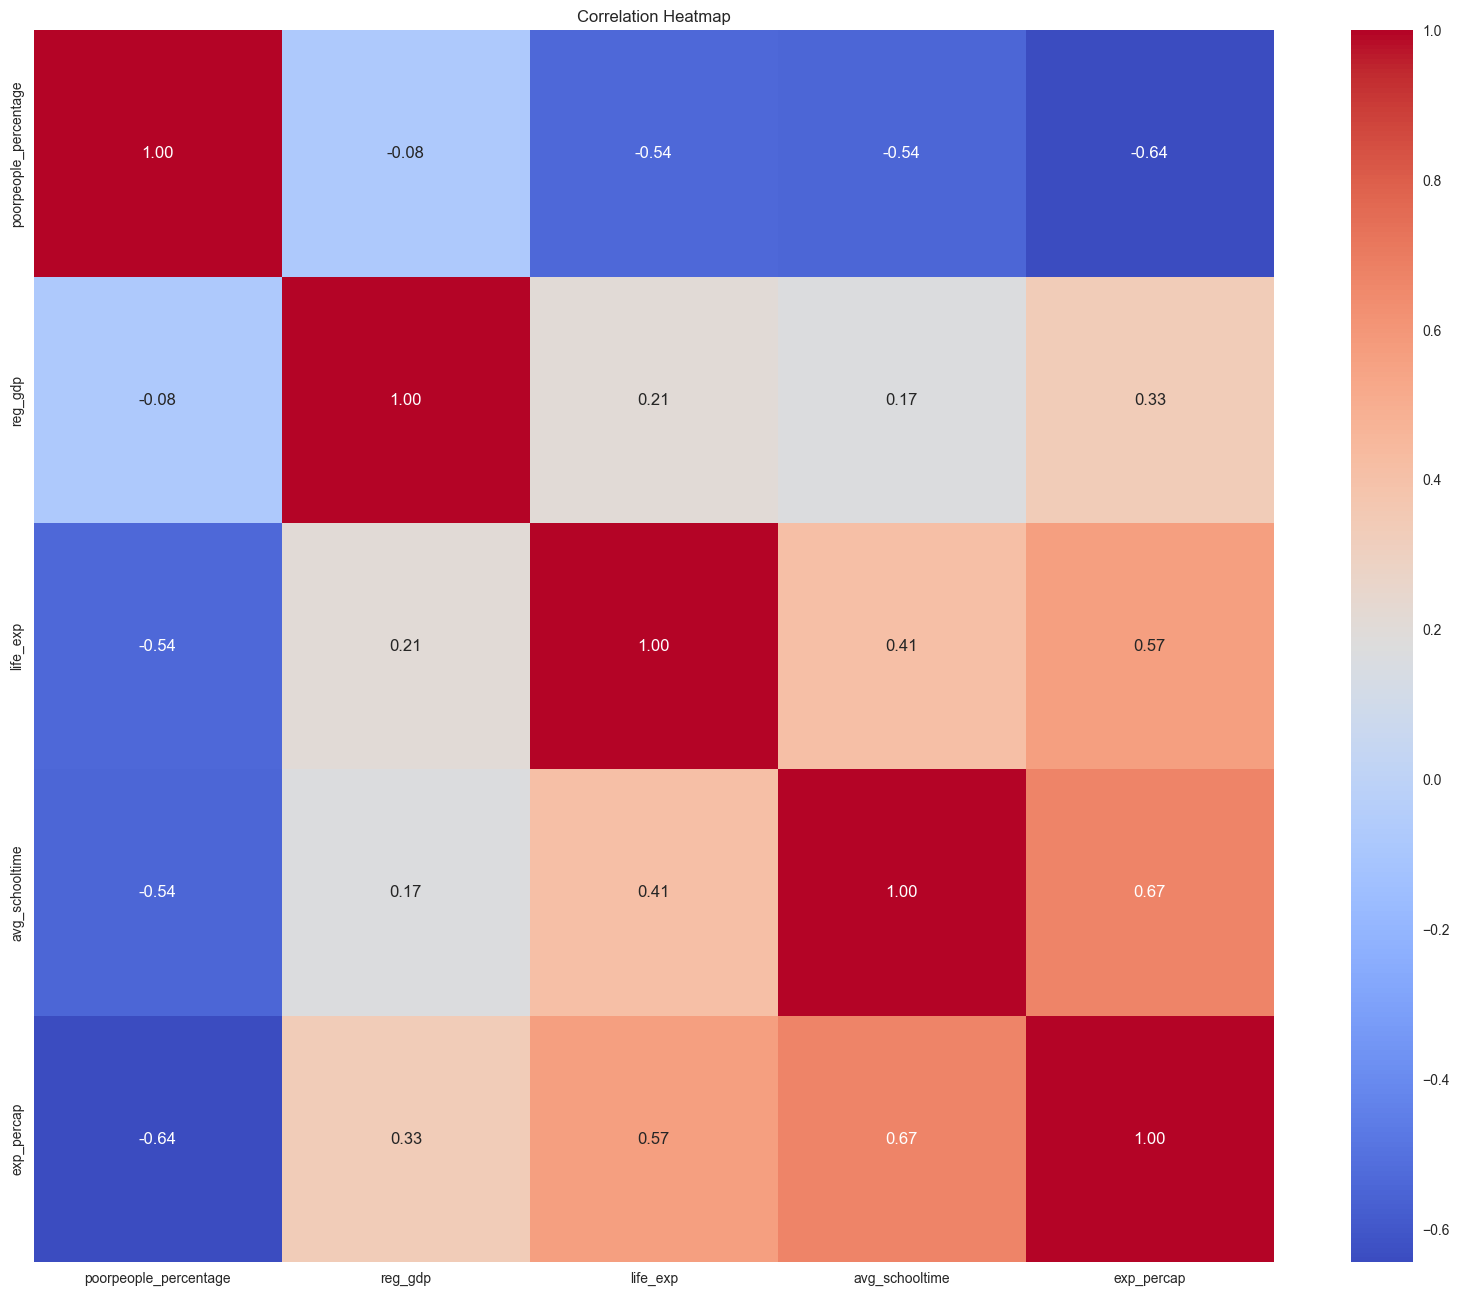

In [109]:
# Correlation Map
correlation_df = df[numerical_features].corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### B. Data Preprocessing

#### 1. Dataset Checking

In [110]:
# Cek missing value
df.isnull().sum()

province                 0
cities_reg               0
poorpeople_percentage    0
reg_gdp                  0
life_exp                 0
avg_schooltime           0
exp_percap               0
dtype: int64

In [111]:
# Cek duplicated value
df.duplicated().sum()

np.int64(0)

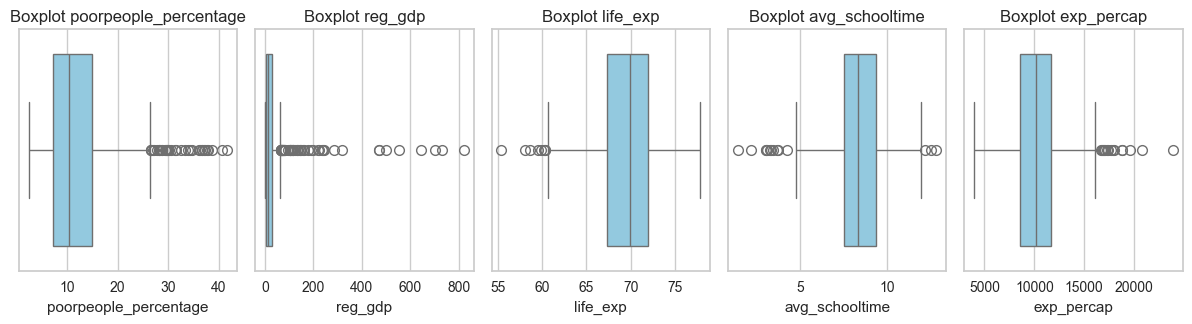

In [112]:
# Deteksi Outlier
plt.figure(figsize=(12,6))
for i, col in enumerate(numerical_features):
    plt.subplot(2, len(numerical_features), i+1)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f"Boxplot {col}")
plt.tight_layout()
plt.show()


#### 2. Standardisasi

In [113]:
# Standarisasi
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

df[numerical_features].describe()

,poorpeople_percentage,reg_gdp,life_exp,avg_schooltime,exp_percap
count,5.140000e+02,5.140000e+02,5.140000e+02,5.140000e+02,5.140000e+02
mean,1.382379e-16,-6.911894e-17,-1.990626e-15,2.073568e-16,-9.676652e-17
std,1.000974e+00,1.000974e+00,1.000974e+00,1.000974e+00,1.000974e+00
min,-1.327682e+00,-4.015093e-01,-4.127119e+00,-4.306641e+00,-2.338843e+00
25%,-6.875381e-01,-3.474436e-01,-6.612004e-01,-5.687354e-01,-6.449763e-01
50%,-2.439999e-01,-2.584620e-01,8.788413e-02,-8.078221e-02,-4.726025e-02
75%,3.508512e-01,-7.075744e-02,6.950445e-01,5.529432e-01,5.136166e-01
max,3.943779e+00,9.327562e+00,2.385463e+00,2.696561e+00,4.996579e+00


### C. Modelling

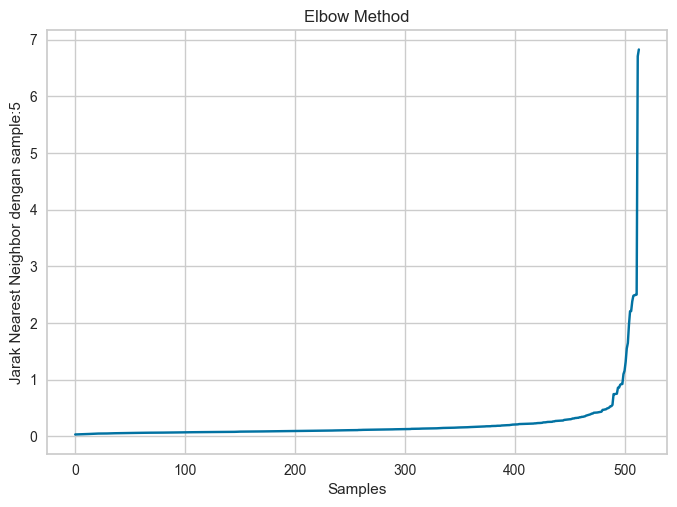

In [114]:
X = df[numerical_features]

#X.drop(columns=["poorpeople_percentage"], inplace=True)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Mencari nilai eps optimal dengan metode k-distance
nearest_neighbors = NearestNeighbors(n_neighbors=5)
neighbors = nearest_neighbors.fit(X_pca)
distances, indices = neighbors.kneighbors(X_pca)

# Urutkan jarak tetangga terdekat
distances = np.sort(distances[:, 4], axis=0)

# Visualisasi untuk menentukan eps
plt.plot(distances)
plt.xlabel("Samples")
plt.ylabel("Jarak Nearest Neighbor dengan sample:5")
plt.title("Elbow Method")
plt.show()

dbscan = DBSCAN(eps=1, min_samples=3)
dbscan_labels = dbscan.fit_predict(X_pca)


In [115]:
X.head()

,poorpeople_percentage,reg_gdp,life_exp,avg_schooltime,exp_percap
0,0.900074,-0.386844,-1.268361,0.640406,-1.170303
1,1.085273,-0.385059,-0.655770,0.149384,-0.570561
2,0.121701,-0.348116,-1.523245,0.272140,-0.790123
3,0.152568,-0.353682,-0.424057,0.757024,-0.845382
4,0.292138,-0.287633,-0.264754,-0.139091,-0.643871


#### D.Evaluasi Clustering

In [116]:
# Sikhoutte Score
silhouette_score_eval = silhouette_score(X, dbscan_labels)
print(f"Silhoutte Score: {silhouette_score_eval}")

Silhoutte Score: 0.5964864412308584


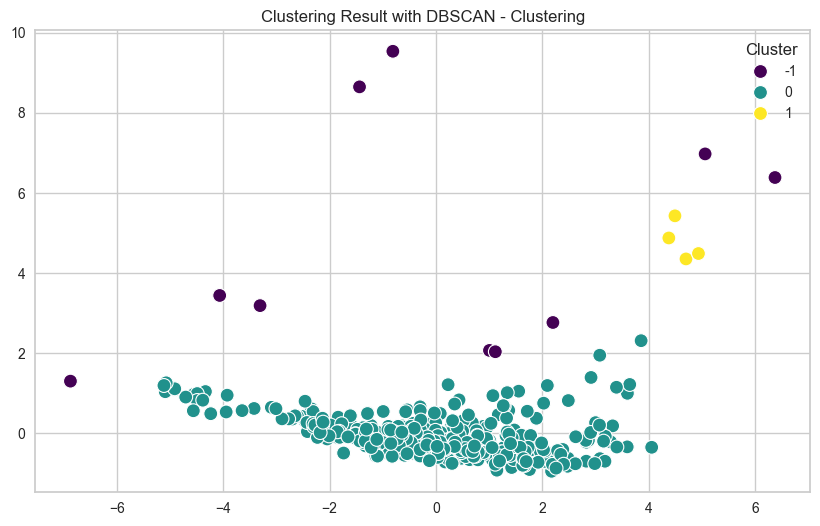

In [117]:
# Visualisasi Clustering

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_labels, palette='viridis', s=100)
plt.title("Clustering Result with DBSCAN - Clustering")
plt.legend(title="Cluster")
plt.show()

### Inverse Data

In [118]:
# Invers StandarScaler
numerical_column = df.select_dtypes(include=['float64','int']).columns
df[numerical_column] = scaler.inverse_transform(df[numerical_column])

# Tambahkan label ke dataframe
df['Cluster'] = dbscan_labels

# Ubah nilai Cluster -1(outliers) menjadi 1
df['Cluster'] = df['Cluster'].replace(-1, 1)
df.head()

,province,cities_reg,poorpeople_percentage,reg_gdp,life_exp,avg_schooltime,exp_percap,Cluster
0,Aceh,Simeulue,18.98,2.275,65.240,9.48,7148.0,0
1,Aceh,Aceh Singkil,20.36,2.425,67.355,8.68,8776.0,0
2,Aceh,Aceh Selatan,13.18,5.531,64.360,8.88,8180.0,0
3,Aceh,Aceh Tenggara,13.41,5.063,68.155,9.67,8030.0,0
4,Aceh,Aceh Timur,14.45,10.616,68.705,8.21,8577.0,0


In [119]:
df["Cluster"].value_counts()

Cluster
0    500
1     14
Name: count, dtype: int64

### Cluster Summary

In [120]:
# Analisis Karakteristik Tiap Cluster
cluster_summary = df.groupby("Cluster").agg({
    "province": lambda x: x.mode()[0],
    "cities_reg": lambda x: x.mode()[0],
    "poorpeople_percentage": ["mean", "min", "max"],
    "reg_gdp": ["mean", "min", "max"],
    "life_exp": ["mean", "min", "max"],
    "avg_schooltime": ["mean", "min", "max"],
    "exp_percap": ["mean", "min", "max"],
}).reset_index()

pd.set_option('display.max_colwidth', None)
print(cluster_summary)

  Cluster     province  cities_reg poorpeople_percentage               \
              <lambda>    <lambda>                  mean   min    max   
0       0   Jawa Timur  Aceh Barat             12.180240  2.38  41.66   
1       1  DKI Jakarta      Bekasi             15.591429  3.56  37.18   

      reg_gdp                   life_exp                avg_schooltime        \
         mean    min      max       mean    min     max           mean   min   
0   23.517284  1.042  283.617  69.614050  57.99  77.855       8.437440  2.16   
1  437.692929  1.271  819.000  69.798571  55.37  74.485       8.407143  1.42   

            exp_percap                   
     max          mean     min      max  
0  12.83  10265.238000  4393.0  19598.0  
1  11.67  12451.571429  3976.0  23888.0  


> Cluster 0: "Wilayah Berkembang dengan Tingkat Kemiskinan Moderat"

Cluster 0 ini mencakup provinsi dan kota/kabupaten dengan karakteristik yang beragam. Rata-rata persentase penduduk miskinnya sekitar 12.18%, meskipun ada juga wilayah dengan persentase kemiskinan yang cukup tinggi (hingga 41.66%). Dari sisi ekonomi, rata-rata pertumbuhan PDRB-nya 23.52, namun dengan rentang yang sangat lebar, menunjukkan adanya sektor ekonomi yang bervariasi di dalamnya.

Di sisi sosial, rata-rata angka harapan hidup di cluster ini adalah 69.61 tahun, dan rata-rata lama sekolah 8.44 tahun. Ini menunjukkan tingkat kesehatan dan pendidikan yang cukup memadai, meski masih ada ruang untuk peningkatan. Pengeluaran per kapita rata-rata Rp 10.265.238 mengindikasikan tingkat daya beli yang bervariasi di antara wilayah-wilayah dalam cluster ini.

> Cluster 1: "Pusat Ekonomi dengan Daya Beli Tinggi"

Cluster 1 ini menonjol sebagai wilayah dengan aktivitas ekonomi yang sangat dinamis. Meskipun rata-rata persentase penduduk miskinnya sedikit lebih tinggi dari Cluster 0, yaitu sekitar 15.59%, PDRB rata-ratanya jauh melampaui Cluster 0, yakni mencapai 437.69. Angka ini mengindikasikan bahwa cluster ini adalah penyumbang utama perekonomian nasional dengan pertumbuhan ekonomi yang sangat pesat.

Dari segi kualitas hidup, rata-rata angka harapan hidup di cluster ini adalah 69.80 tahun, dan rata-rata lama sekolah 8.41 tahun. Angka-angka ini tidak jauh berbeda dengan Cluster 0, namun dengan dukungan ekonomi yang lebih kuat. Pengeluaran per kapita rata-rata Rp 12.451.571 yang lebih tinggi dari Cluster 0 semakin menguatkan statusnya sebagai wilayah dengan daya beli yang kuat.

In [121]:
#save dataset
df.to_csv("../data/segmentasi_labelled_dataset.csv", index=False)